# Autoencoder Multivariate Training (Expiriment 3)

 Vinayak Sharma
  
 This notebook aims to train an autoencoder on univariate timeseries data from EKS Performance metrics for MANY NODES. The training data is 'non-anomalous'. 

 The model and implementation techniques can be found in the following github: https://github.com/emerelte/kad
 
 The research paper that this work is based on can be found here: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9925210

------

In [59]:
##global variable
timesteps = 40
time_steps = 40
batch_size = 36
n_samples = batch_size*1000
features = ['node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

## Imports

In [60]:
# !pip install -r /root/eks-ml-pipeline/modeling/kad/kad/requirements.txt
# # # !pip install keras
# # # !pip install tensorflow

In [61]:
# !pip install tensorflow

In [62]:
# import matplotlib as mpl
# mpl.rcParams.keys()

In [63]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
import keras
from keras import layers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from autoencoder_model_dish_5g import autoencoder_model_dish_5g

from sklearn.model_selection import train_test_split

import _pickle as cPickle


In [64]:
import logging
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt


import random 


In [65]:
pd.set_option('display.max_rows', None)

First lets read in our training sample set 

In [66]:
##isolate the first days worth of data
training_df_full = pd.read_parquet('/root/healthy_clusters_node_month.parquet')
training_df_full['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')
training_df_full = training_df_full[(training_df_full['Timestamp'] > '2022-06-01') & (training_df_full['Timestamp'] < '2022-06-02')]
training_df_full = training_df_full.sort_values(by='Timestamp')

In [67]:
training_df_full.shape

(77642, 19)

In [68]:
columns_to_keep = ['Timestamp','InstanceId','node_cpu_utilization','node_memory_utilization','node_network_total_bytes']

In [69]:
training_df = training_df_full.drop(training_df_full.columns.difference(columns_to_keep),1, inplace=False)
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'], unit='ms')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [70]:
training_df.shape

(77642, 5)

In [71]:
len(training_df)

77642

In [72]:
training_df = training_df.dropna()

In [73]:
test_df = training_df.copy()
training_df = training_df[training_df.InstanceId != 'i-0b36e8825c482f762']

-----

# TRAIN DATASET: Build out Dataset for training on many nodes

now we are starting to build out a training dataset for two nodes. This will prove our understanding of how to model can generalize across many EC2 instances. 

In [74]:
## for normalization
# scaler = StandardScaler()

scaler = StandardScaler()

In [75]:
instance_dfs =[]
for instance in training_df['InstanceId'].unique():
    if(len(training_df[training_df.InstanceId == instance]) >60):
        instance_dfs.append(training_df[training_df.InstanceId == instance].sort_values(by='Timestamp')\
                            .reset_index(drop=True))

In [76]:

x_train = np.zeros((n_samples,time_steps,len(features)))
for b in range(n_samples):
    
    ##pick random df, and normalize
    df = random.choice(instance_dfs)
    df = df.drop(columns = ['InstanceId'])
    df = df.set_index('Timestamp')
    df = df.sort_index()
    df[features] = scaler.fit_transform(df[features])
    
    
    
    sample = np.zeros((n_samples,len(features)))
    ##make sure length of df is atleast 40
    first_time = random.choice(range(len(df)-time_steps))
    df.head()
    sample = df[features].iloc[first_time:first_time+time_steps]
    x_train[b] = sample

x_train.shape

(36000, 40, 3)

our xtrain shape has the following properties: (sample size, time steps, numFeatures)

-------

# TEST DATASET: Build out Dataset for testing on one node

In [80]:
# test_df = test_df[test_df.InstanceId == 'i-0b36e8825c482f762']

In [81]:
# test_df.head()

In [82]:
# ## drop the instanceId
# test_df = test_df.drop("InstanceId",1, inplace=False)


# ##set timestamp as the index
# test_df = test_df.set_index('Timestamp')

# ##normalize test_df 
# test_df[features] = scaler.fit_transform(test_df[features])


# ##ensure the data is sorted!!
# test_df = test_df.sort_index()

----

# Model Time

----

### First we train

In [83]:
model = autoencoder_model_dish_5g(batch_size = batch_size, time_steps = time_steps, epochs = 250,nuerons=128)

In [84]:
# model: i_model.IModel = autoencoder_model.AutoEncoderModel(batch_size = batch_size, time_steps = time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 40, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 40, 3)            387       
 ibuted)                                                

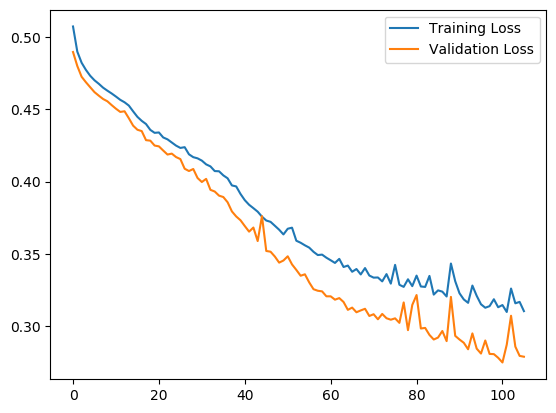

1125/1125 [==============================] - 23s 19ms/step
error_threshold 2.9894264728600417


In [85]:
val_err = model.train(x_train)


### 1 LSTM 128 Units {per encoder and decoder}
### 1 day of data, tensor size: [36k,20ts,3f]